In [1]:
# Gain modulation RNN with oja learning on weight matrix
import numpy as np
import sys
sys.path.append("..")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
from torch import tensor
import seaborn as sns
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
period = 120
time_constant = 100 #ms
timestep = 10 #ms
num_inputs = 1
num_nodes = 32

In [29]:
%%capture
'''
# find the correct weights sum under perturbation
simu_epochs = 10000
ndata = simu_epochs * period
time = ndata * timestep

# define inputs and targets
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)
inputs += 0.1  # perturbation

# initialize
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = [1]*excite_num + [-1]*(num_nodes-excite_num)
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)
# Initializing matrix
np.random.seed(1)
connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(size=(num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
input_weight_matrix = np.random.normal(0, 1/np.sqrt(num_inputs), (num_inputs, num_nodes)) # useless
init_activations = np.zeros((num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))
output_weight_matrix = np.ones((1, num_nodes))
# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type
init_weight_matrix = weight_matrix.copy()

# training
backprop_lr = 0.1
loss_func = nn.MSELoss()
has_backprop = False
simu_losses = []
simu_outputs = []
last_epoch_loss = 0

for epoch in range(simu_epochs):

    # skip first epoch
    if epoch > 0 and has_backprop == False:
        has_backprop = True
        print('backprop start!!!')

    # record
    epoch_losses = []

    # go through one period
    for idx in range(period):
        i = epoch * period + idx  # index of data
        
        # Creating RNN
        network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                    time_constant=time_constant, timestep=timestep)
        
        # forward
        this_input = inputs[i].item()
        this_output = network.forward(this_input).squeeze()
        this_activations = network.activation.clone()

        # get loss
        this_target = tensor(targets[i].item())
        loss_val = loss_func(this_output, this_target)

        # backprop
        if has_backprop:
            opt = torch.optim.SGD([network.weight_matrix], lr=backprop_lr)
            loss_val.backward()
            opt.step()
            opt.zero_grad()
        # weight boundary
        network.weight_matrix = network.weight_matrix * network.connectivity_matrix
        network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
        # update init weights
        weight_matrix = network.weight_matrix.detach().numpy()

        # update activations
        last_activations = this_activations.clone() # for hebbian
        init_activations = this_activations.detach().numpy()

        # record
        epoch_losses.append(loss_val.item())
        simu_outputs.append(this_output.item())

    # epoch mean
    mean_epoch_loss = np.mean(epoch_losses)
    simu_losses.append(mean_epoch_loss)
    last_epoch_loss = mean_epoch_loss.copy()

    # print
    if epoch % 20 == 0:
        excite_weight_sum = np.sum(weight_matrix * (weight_type > 0))
        inhibit_weight_sum = np.sum(weight_matrix * (weight_type < 0))
        print(f'Epoch {epoch+1}, Loss: {mean_epoch_loss}\n\
                Excite weight sum: {excite_weight_sum}, Inhibit weight sum: {inhibit_weight_sum}')
'''

## Loading Trained Weights

In [3]:
with open('../weights/SIN2_bphebbpt_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [4]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'gain_changes', 'shift_changes', 'init_weight', 'init_activations'])

In [5]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
gain_changes = np.array(weight_history['gain_changes'])
shift_changes = np.array(weight_history['shift_changes'])
init_weight_matrix = np.array(weight_history['init_weight'])
# weights = weight_history['weights']
init_activations = np.array(weight_history['init_activations'])

## Convergence Test

In [12]:
simu_epochs = 10000
ndata = simu_epochs * period
time = ndata * timestep

# define inputs and targets
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

In [13]:
backprop_lr = 0.1
loss_func = nn.MSELoss()
has_perturb = False
has_hebbian = True
has_backprop = False
hebbian_lr = 0.000001
max_hebbian_lr = 0.000001
hebbian_up_rate = max_hebbian_lr / 200
hebb_alpha_ext = 415
hebb_alpha_inh = 375

init_gain = gains.copy()
init_shift = shifts.copy()
weight_matrix = np.array(weight_history['trained weights'])
init_activations = np.array(weight_history['init_activations'])
last_activations = tensor(np.array(weight_history['init_activations']), dtype=torch.float32)
theo_gain = np.ones((num_nodes, 1))
theo_shift = np.zeros((num_nodes, 1))

simu_losses = []
gain_changes = []
shift_changes = []
simu_outputs = []
last_epoch_loss = 0

for epoch in tqdm(range(simu_epochs)):

    # update hebbian learning rate, once per epoch
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_up_rate

    # record
    epoch_losses = []
    epoch_gain_changes = []
    epoch_shift_changes = []

    # go through one period
    for idx in range(period):
        i = epoch * period + idx  # index of data
        
        # Creating RNN
        network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                    time_constant=time_constant, timestep=timestep)
        
        # forward
        this_input = inputs[i].item()
        this_output = network.forward(this_input).squeeze()
        this_activations = network.activation.clone()

        # get loss
        this_target = tensor(targets[i].item())
        loss_val = loss_func(this_output, this_target)

        # backprop
        if has_backprop:
            opt = torch.optim.SGD([network.gain, network.shift], lr=backprop_lr)
            loss_val.backward()
            opt.step()
            opt.zero_grad()
        init_gain = network.gain.detach().numpy()
        init_shift = network.shift.detach().numpy()
        # gain_change = np.linalg.norm(init_gain - gains, 2)
        # shift_change = np.linalg.norm(init_shift - shifts, 2)
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # update weights by hebbian learning
        if has_hebbian:
            # Calculate Hebbian weight updates
            hebbian_update = torch.matmul(last_activations, this_activations.T)
            hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
            # Normalized Hebbian learning
            network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
            tmp_weights_ext = network.weight_matrix[network.weight_type]
            tmp_weights_inh = network.weight_matrix[~network.weight_type]
            network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
            network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
            # weight boundary
            network.weight_matrix = network.weight_matrix * network.connectivity_matrix
            network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
        # update init weights
        weight_matrix = network.weight_matrix.detach().numpy()

        # update activations
        last_activations = this_activations.clone() # for hebbian
        init_activations = this_activations.detach().numpy()

        # record
        epoch_losses.append(loss_val.item())
        epoch_gain_changes.append(gain_change)
        epoch_shift_changes.append(shift_change)
        simu_outputs.append(this_output.item())

    # epoch mean
    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_gain_change = np.mean(epoch_gain_changes)
    mean_epoch_shift_change = np.mean(epoch_shift_changes)
    simu_losses.append(mean_epoch_loss)
    gain_changes.append(mean_epoch_gain_change)
    shift_changes.append(mean_epoch_shift_change)
    last_epoch_loss = mean_epoch_loss.copy()

    # print
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{simu_epochs}, Loss: {mean_epoch_loss}, GC:{mean_epoch_gain_change},SC:{mean_epoch_shift_change}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1/10000, Loss: 0.000497261041307695, GC:7.617372498230297,SC:5.887066158133663
Epoch 11/10000, Loss: 0.0004091179495884963, GC:7.617372498230297,SC:5.887066158133663
Epoch 21/10000, Loss: 0.0004117077574584016, GC:7.617372498230297,SC:5.887066158133663
Epoch 31/10000, Loss: 0.0004137252212139231, GC:7.617372498230297,SC:5.887066158133663
Epoch 41/10000, Loss: 0.0004168209556927612, GC:7.617372498230297,SC:5.887066158133663
Epoch 51/10000, Loss: 0.000418721029417668, GC:7.617372498230297,SC:5.887066158133663
Epoch 61/10000, Loss: 0.0004212910378936859, GC:7.617372498230297,SC:5.887066158133663
Epoch 71/10000, Loss: 0.0004244018982594374, GC:7.617372498230297,SC:5.887066158133663
Epoch 81/10000, Loss: 0.00042710403145396946, GC:7.617372498230297,SC:5.887066158133663
Epoch 91/10000, Loss: 0.00042987398743434826, GC:7.617372498230297,SC:5.887066158133663
Epoch 101/10000, Loss: 0.00043399566721997, GC:7.617372498230297,SC:5.887066158133663
Epoch 111/10000, Loss: 0.0004361291850604706,

## Perturb 10000 epochs

In [55]:
simu_epochs = 30000
ndata = simu_epochs * period
time = ndata * timestep

# define inputs and targets
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# define noise
perturb_start = 50
perturb_last = 10000
inputs[perturb_start*period:(perturb_start+perturb_last)*period] += 0.1

In [56]:
backprop_lr = 0.1
loss_func = nn.MSELoss()
has_perturb = False
has_hebbian = False
has_backprop = True
hebbian_lr = 0.000001
max_hebbian_lr = 0.000001
hebbian_up_rate = max_hebbian_lr / 200
hebb_alpha_ext = 415
hebb_alpha_inh = 375

init_gain = gains.copy()
init_shift = shifts.copy()
# init_activations = np.zeros((num_nodes, 1))
theo_gain = np.ones((num_nodes, 1))
theo_shift = np.zeros((num_nodes, 1))

simu_losses = []
gain_changes = []
shift_changes = []
simu_outputs = []
last_epoch_loss = 0

for epoch in tqdm(range(simu_epochs)):

    if epoch == perturb_start:
        has_perturb = True
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation start!!!")
    if epoch == perturb_start + perturb_last:
        has_perturb = False
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation end!!!")

    # start hebbian and shrinkage
    if has_perturb and epoch > perturb_start + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("perturb learning start!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("origin learning start!!!")

    # update hebbian learning rate, once per epoch
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_up_rate

    # record
    epoch_losses = []
    epoch_gain_changes = []
    epoch_shift_changes = []

    # go through one period
    for idx in range(period):
        i = epoch * period + idx  # index of data
        
        # Creating RNN
        network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                    time_constant=time_constant, timestep=timestep)
        
        # forward
        this_input = inputs[i].item()
        this_output = network.forward(this_input).squeeze()
        this_activations = network.activation.clone()

        # get loss
        this_target = tensor(targets[i].item())
        loss_val = loss_func(this_output, this_target)

        # backprop
        if has_backprop:
            opt = torch.optim.SGD([network.gain, network.shift], lr=backprop_lr)
            loss_val.backward()
            opt.step()
            opt.zero_grad()
        init_gain = network.gain.detach().numpy()
        init_shift = network.shift.detach().numpy()
        # gain_change = np.linalg.norm(init_gain - gains, 2)
        # shift_change = np.linalg.norm(init_shift - shifts, 2)
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # update weights by hebbian learning
        if has_hebbian:
            # Calculate Hebbian weight updates
            hebbian_update = torch.matmul(last_activations, this_activations.T)
            hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
            # Normalized Hebbian learning
            network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
            tmp_weights_ext = network.weight_matrix[network.weight_type]
            tmp_weights_inh = network.weight_matrix[~network.weight_type]
            network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
            network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
            # weight boundary
            network.weight_matrix = network.weight_matrix * network.connectivity_matrix
            network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
        # update init weights
        weight_matrix = network.weight_matrix.detach().numpy()

        # update activations
        last_activations = this_activations.clone() # for hebbian
        init_activations = this_activations.detach().numpy()

        # record
        epoch_losses.append(loss_val.item())
        epoch_gain_changes.append(gain_change)
        epoch_shift_changes.append(shift_change)
        simu_outputs.append(this_output.item())

    # epoch mean
    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_gain_change = np.mean(epoch_gain_changes)
    mean_epoch_shift_change = np.mean(epoch_shift_changes)
    simu_losses.append(mean_epoch_loss)
    gain_changes.append(mean_epoch_gain_change)
    shift_changes.append(mean_epoch_shift_change)
    last_epoch_loss = mean_epoch_loss.copy()

    # print
    if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{simu_epochs}, Loss: {mean_epoch_loss}, GC:{mean_epoch_gain_change},SC:{mean_epoch_shift_change}')

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1/20000, Loss: 0.00037769229800043526, GC:7.618184474934529,SC:5.890683086829373
Epoch 11/20000, Loss: 0.00037757333274959966, GC:7.618108353913417,SC:5.890692859778675
Epoch 21/20000, Loss: 0.0003774432384445229, GC:7.618037872476822,SC:5.8907026200540304
Epoch 31/20000, Loss: 0.0003773017272162171, GC:7.6179728418596975,SC:5.890711519431153
Epoch 41/20000, Loss: 0.00037715262204534027, GC:7.617908184409455,SC:5.890718660859432
perturbation start!!!
Epoch 51/20000, Loss: 0.001915206505683879, GC:7.611489059370639,SC:5.85792853358688
Epoch 61/20000, Loss: 0.0011631664028700565, GC:7.6210264023918475,SC:5.840371430843716
Epoch 71/20000, Loss: 0.0016071405528596946, GC:7.634037472189692,SC:5.8263875993782674
Epoch 81/20000, Loss: 0.002214088039873996, GC:7.646963374034972,SC:5.813993874824261
Epoch 91/20000, Loss: 0.00282113168968996, GC:7.659314993327727,SC:5.803125171653725
Epoch 101/20000, Loss: 0.0033895640893369717, GC:7.671061278809642,SC:5.7935487427545205
Epoch 111/20000, L

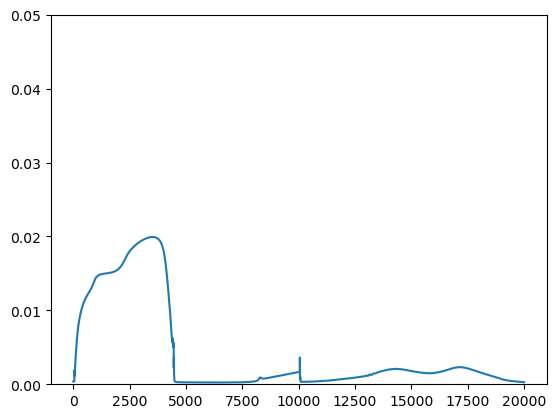

In [57]:
plt.plot(simu_losses)
plt.ylim([0, 0.05])
plt.show()

In [36]:
# plt.subplots(figsize=(10, 5))
# plt.plot(time_points, targets, label='targets')
# plt.plot(time_points, simu_outputs, label='outputs')
# plt.legend()
# plt.show()

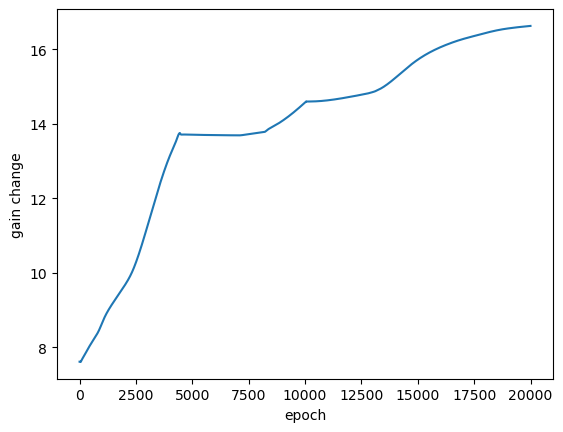

In [58]:
plt.plot(np.arange(len(gain_changes)), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

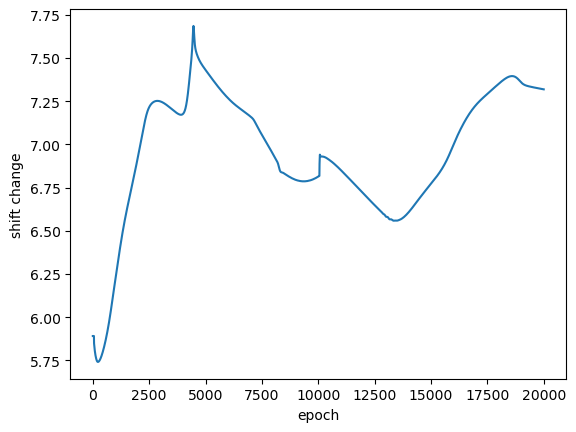

In [59]:
plt.plot(np.arange(len(shift_changes)), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

## Different Lasting

In [60]:
simu_epochs = 30000
ndata = simu_epochs * period
time = ndata * timestep
dt = timestep/time_constant
time_points = np.arange(ndata).reshape(-1, 1)

# define noise
perturb_start = 50
perturb_lasts = [5000, 10000, 15000]

# record
all_simu_losses = []
all_gain_changes = []
all_shift_changes = []

for perturb_last in perturb_lasts:

    print(f"perturb_last: {perturb_last}")

    # define inputs and targets
    inputs = (1 + np.sin(time_points/60*np.pi))/2
    targets = (1 + np.sin((time_points+1)/60*np.pi))/2
    inputs = inputs.reshape(-1, 1)
    targets = targets.reshape(-1, 1)
    inputs[perturb_start*period:(perturb_start+perturb_last)*period] += 0.1

    # init
    backprop_lr = 0.01
    loss_func = nn.MSELoss()
    has_perturb = False
    has_hebbian = False
    has_backprop = True
    hebbian_lr = 0.000001
    max_hebbian_lr = 0.000001
    hebbian_up_rate = max_hebbian_lr / 200
    hebb_alpha_ext = 415
    hebb_alpha_inh = 375
    init_gain = gains.copy()
    init_shift = shifts.copy()
    weight_matrix = np.array(weight_history['trained weights'])
    init_activations = np.array(weight_history['init_activations'])
    # init_activations = np.zeros((num_nodes, 1))
    theo_gain = np.ones((num_nodes, 1))
    theo_shift = np.zeros((num_nodes, 1))

    simu_losses = []
    gain_changes = []
    shift_changes = []
    simu_outputs = []
    last_epoch_loss = 0

    for epoch in tqdm(range(simu_epochs)):

        if epoch == perturb_start:
            has_perturb = True
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation start!!!")
        if epoch == perturb_start + perturb_last:
            has_perturb = False
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation end!!!")

        # start hebbian and shrinkage
        if has_perturb and epoch > perturb_start + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("perturb learning start!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 100 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("origin learning start!!!")

        # update hebbian learning rate, once per epoch
        if has_hebbian and hebbian_lr < max_hebbian_lr:
            hebbian_lr += hebbian_up_rate

        # record
        epoch_losses = []
        epoch_gain_changes = []
        epoch_shift_changes = []

        # go through one period
        for idx in range(period):
            i = epoch * period + idx  # index of data
            
            # Creating RNN
            network = RNN(weight_matrix, connectivity_matrix, init_activations, init_gain, init_shift, input_weight_matrix, output_weight_matrix,
                        time_constant=time_constant, timestep=timestep)
            
            # forward
            this_input = inputs[i].item()
            this_output = network.forward(this_input).squeeze()
            this_activations = network.activation.clone()

            # get loss
            this_target = tensor(targets[i].item())
            loss_val = loss_func(this_output, this_target)

            # backprop
            if has_backprop:
                opt = torch.optim.SGD([network.gain, network.shift], lr=backprop_lr)
                loss_val.backward()
                opt.step()
                opt.zero_grad()
            init_gain = network.gain.detach().numpy()
            init_shift = network.shift.detach().numpy()
            # gain_change = np.linalg.norm(init_gain - gains, 2)
            # shift_change = np.linalg.norm(init_shift - shifts, 2)
            gain_change = np.linalg.norm(init_gain - theo_gain, 2)
            shift_change = np.linalg.norm(init_shift - theo_shift, 2)

            # update weights by hebbian learning
            if has_hebbian:
                # Calculate Hebbian weight updates
                hebbian_update = torch.matmul(last_activations, this_activations.T)
                hebbian_update = hebbian_update * (network.weight_type * 2 - 1) * network.connectivity_matrix
                # Normalized Hebbian learning
                network.weight_matrix = network.weight_matrix + hebbian_lr * hebbian_update
                tmp_weights_ext = network.weight_matrix[network.weight_type]
                tmp_weights_inh = network.weight_matrix[~network.weight_type]
                network.weight_matrix[network.weight_type] = tmp_weights_ext / torch.sum(torch.abs(tmp_weights_ext)) * hebb_alpha_ext
                network.weight_matrix[~network.weight_type] = tmp_weights_inh / torch.sum(torch.abs(tmp_weights_inh)) * hebb_alpha_inh
                # weight boundary
                network.weight_matrix = network.weight_matrix * network.connectivity_matrix
                network.weight_matrix[network.weight_matrix * (network.weight_type * 2 - 1) < 0] = 0
            # update init weights
            weight_matrix = network.weight_matrix.detach().numpy()

            # update activations
            last_activations = this_activations.clone() # for hebbian
            init_activations = this_activations.detach().numpy()

            # record
            epoch_losses.append(loss_val.item())
            epoch_gain_changes.append(gain_change)
            epoch_shift_changes.append(shift_change)
            simu_outputs.append(this_output.item())

        # epoch mean
        mean_epoch_loss = np.mean(epoch_losses)
        mean_epoch_gain_change = np.mean(epoch_gain_changes)
        mean_epoch_shift_change = np.mean(epoch_shift_changes)
        simu_losses.append(mean_epoch_loss)
        gain_changes.append(mean_epoch_gain_change)
        shift_changes.append(mean_epoch_shift_change)
        last_epoch_loss = mean_epoch_loss.copy()

        # print
        if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{simu_epochs}, Loss: {mean_epoch_loss}, GC:{mean_epoch_gain_change},SC:{mean_epoch_shift_change}')
        
    # record
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)

perturb_last: 5000


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1/30000, Loss: 0.00041485054321253043, GC:7.617605042313898,SC:5.888235196192487
Epoch 11/30000, Loss: 0.00029332317313594906, GC:7.618225395513207,SC:5.890663182067154
Epoch 21/30000, Loss: 0.00029302309012067725, GC:7.618267504727461,SC:5.890765728677611
Epoch 31/30000, Loss: 0.000292690559944068, GC:7.618303060019599,SC:5.890829355532229
Epoch 41/30000, Loss: 0.0002923742122246035, GC:7.618340264770695,SC:5.890892780082757
perturbation start!!!
Epoch 51/30000, Loss: 0.005704698521557106, GC:7.616487186862949,SC:5.880822296210472
Epoch 61/30000, Loss: 0.0021049804269457203, GC:7.614624770396409,SC:5.8542827865039
Epoch 71/30000, Loss: 0.0017325130492712522, GC:7.6175802620123685,SC:5.851929209606811
Epoch 81/30000, Loss: 0.0015807615891247906, GC:7.620210620599324,SC:5.850256355001895
Epoch 91/30000, Loss: 0.0015294338337431175, GC:7.622632584367985,SC:5.84877660069077
Epoch 101/30000, Loss: 0.0015256139601770968, GC:7.62487147806663,SC:5.847448957281715
Epoch 111/30000, Loss: 

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1/30000, Loss: 0.00041485054321253043, GC:7.617605042313898,SC:5.888235196192487
Epoch 11/30000, Loss: 0.00029332317313594906, GC:7.618225395513207,SC:5.890663182067154
Epoch 21/30000, Loss: 0.00029302309012067725, GC:7.618267504727461,SC:5.890765728677611
Epoch 31/30000, Loss: 0.000292690559944068, GC:7.618303060019599,SC:5.890829355532229
Epoch 41/30000, Loss: 0.0002923742122246035, GC:7.618340264770695,SC:5.890892780082757
perturbation start!!!
Epoch 51/30000, Loss: 0.005704698521557106, GC:7.616487186862949,SC:5.880822296210472
Epoch 61/30000, Loss: 0.0021049804269457203, GC:7.614624770396409,SC:5.8542827865039
Epoch 71/30000, Loss: 0.0017325130492712522, GC:7.6175802620123685,SC:5.851929209606811
Epoch 81/30000, Loss: 0.0015807615891247906, GC:7.620210620599324,SC:5.850256355001895
Epoch 91/30000, Loss: 0.0015294338337431175, GC:7.622632584367985,SC:5.84877660069077
Epoch 101/30000, Loss: 0.0015256139601770968, GC:7.62487147806663,SC:5.847448957281715
Epoch 111/30000, Loss: 

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1/30000, Loss: 0.00041485054321253043, GC:7.617605042313898,SC:5.888235196192487
Epoch 11/30000, Loss: 0.00029332317313594906, GC:7.618225395513207,SC:5.890663182067154
Epoch 21/30000, Loss: 0.00029302309012067725, GC:7.618267504727461,SC:5.890765728677611
Epoch 31/30000, Loss: 0.000292690559944068, GC:7.618303060019599,SC:5.890829355532229
Epoch 41/30000, Loss: 0.0002923742122246035, GC:7.618340264770695,SC:5.890892780082757
perturbation start!!!
Epoch 51/30000, Loss: 0.005704698521557106, GC:7.616487186862949,SC:5.880822296210472
Epoch 61/30000, Loss: 0.0021049804269457203, GC:7.614624770396409,SC:5.8542827865039
Epoch 71/30000, Loss: 0.0017325130492712522, GC:7.6175802620123685,SC:5.851929209606811
Epoch 81/30000, Loss: 0.0015807615891247906, GC:7.620210620599324,SC:5.850256355001895
Epoch 91/30000, Loss: 0.0015294338337431175, GC:7.622632584367985,SC:5.84877660069077
Epoch 101/30000, Loss: 0.0015256139601770968, GC:7.62487147806663,SC:5.847448957281715
Epoch 111/30000, Loss: 

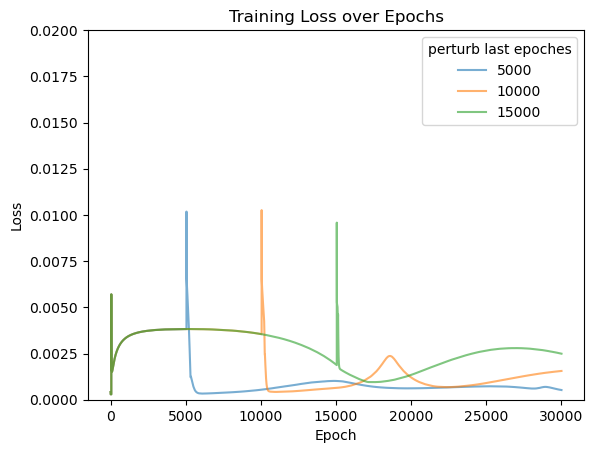

In [61]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=perturb_lasts[i], alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.02])
plt.title('Training Loss over Epochs')
plt.legend(title='perturb last epoches')
plt.savefig('fig/0122_SIN2_perturb_loss.png')
plt.show()

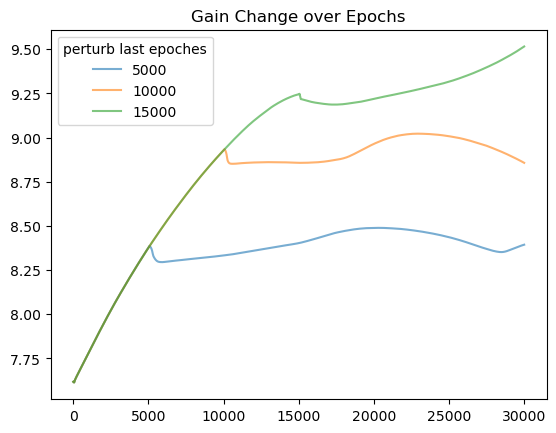

In [62]:
for i, gain_changes in enumerate(all_gain_changes):
    plt.plot(np.arange(simu_epochs), gain_changes, label=perturb_lasts[i], alpha=0.6)
plt.title('Gain Change over Epochs')
plt.legend(title='perturb last epoches')
plt.savefig('fig/0122_SIN2_perturb_gc.png')

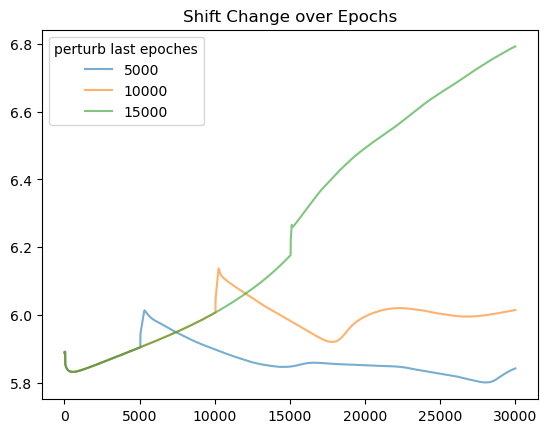

In [63]:
for i,shift_changes in enumerate(all_shift_changes):
    plt.plot(np.arange(simu_epochs), shift_changes, label=perturb_lasts[i], alpha=0.6)
plt.title('Shift Change over Epochs')
plt.legend(title='perturb last epoches')
plt.savefig('fig/0122_SIN2_perturb_sc.png')